In [1]:
#Statsmodels SARIMAX forecasting
#Goal of this notebook is to prove that we can predict a future pace, with given exogenous variables, and construct a confidence interval around the 
#prediction.

In [68]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

In [89]:
race_df2 = pd.read_csv('./data/races/athlete_1/athlete_1_race_2_3_mo_Running_extra_cols.csv', index_col='date')

try:
    race_df2['elev_gain'] = race_df2['elev_gain'].str.replace(',', '').astype(float)
except:
    print(type(race_df2['elev_gain'][0]))

try:
    race_df2['elev_loss'] = race_df2['elev_loss'].str.replace(',', '').astype(float)
except:
    print(type(race_df2['elev_loss'][0]))

try:
    race_df2['calories'] = race_df2['calories'].str.replace(',', '').astype(float)
except:
    print(race_df2['calories'].info())

#Define the exogenous and endogenous variables
exog = race_df2[race_df2['is_race']==0][['distance', 'calories','elev_gain', 'elev_loss', 'avg_run_cadence']] #, 'avg_stride_length', 'avg_ground_contact_time']]

endog = race_df2[race_df2['is_race']==0]['spd_ft_s']

<class 'numpy.int64'>
<class 'numpy.int64'>


In [90]:
race_df2.index = pd.to_datetime(race_df2.index).to_period("D")

In [91]:
len(race_df2)

39

In [92]:
race_df2['spd_ft_s'].autocorr(7)

0.19501043616310165

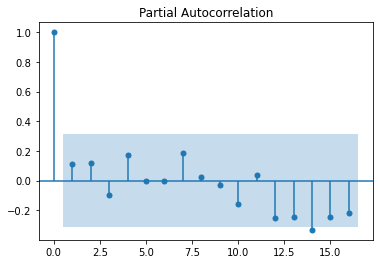

In [93]:
plot_pacf(race_df2['spd_ft_s']*race_df2['intensity']);

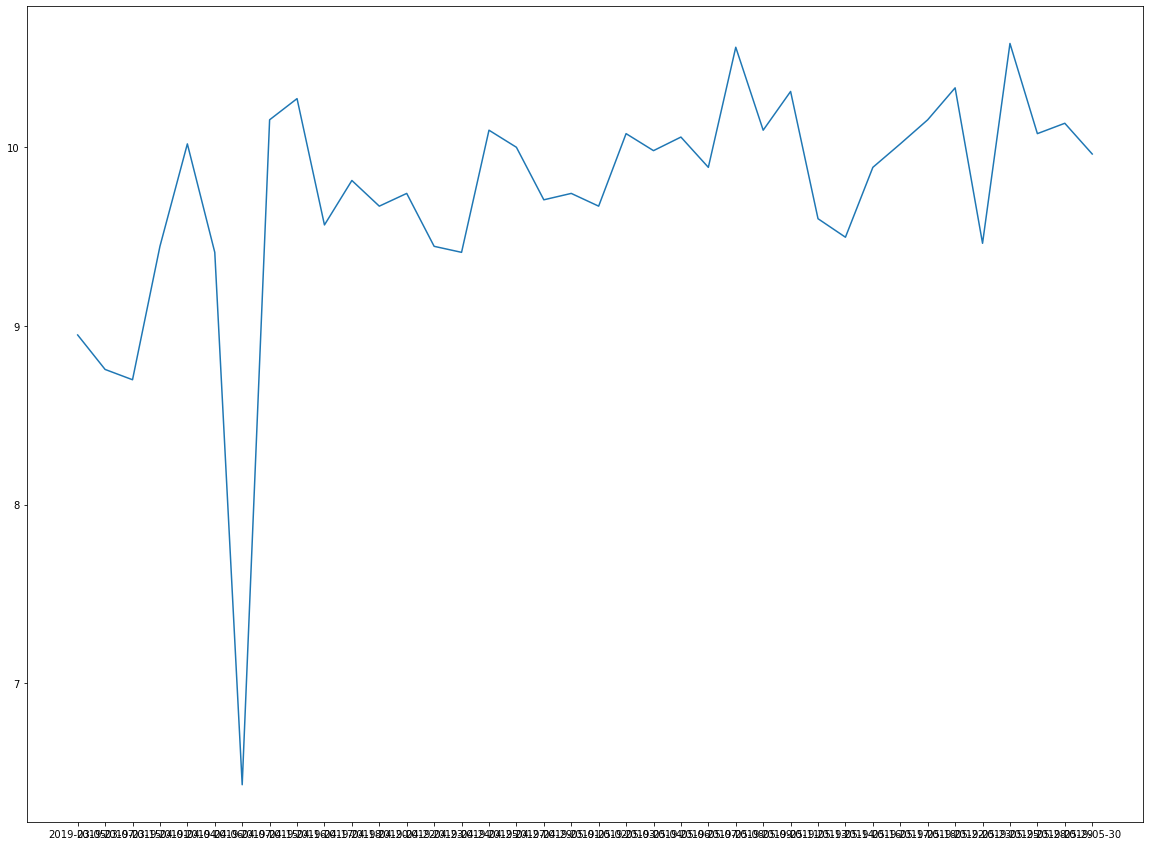

In [94]:
plt.figure(figsize = (20,15))
plt.plot(endog)

In [95]:
#Define the model:
model = sm.tsa.SARIMAX(endog = endog, exog = exog, order=(1, 0, 0), trend='t')

/Users/Keith/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/Keith/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [96]:
results = model.fit()

/Users/Keith/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [97]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:               spd_ft_s   No. Observations:                   38
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  -2.377
Date:                Wed, 24 Feb 2021   AIC                             20.753
Time:                        19:22:56   BIC                             33.854
Sample:                             0   HQIC                            25.414
                                 - 38                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
drift               0.0013      0.008      0.156      0.876      -0.015       0.018
distance           -0.0617      0.109     -0.569      0.569      -0.274       0.151
calories            0.0002      

In [98]:
print(results.forecast(exog = [[13.14, 1638, 354, 604, 167]]))

38    11.227157
dtype: float64


/Users/Keith/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [99]:
race_df2[race_df2['is_race']==1]['spd_ft_s']

date
2019-06-02    11.478261
Freq: D, Name: spd_ft_s, dtype: float64

In [100]:
#We get the distance and the elevation gain and loss from the course.
#calories are estimated from average calorie/mile burned, multiplied by distance.
#cadence input is average cadence over all previous training > 10 miles (long runs)
fcast_res1 = results.get_forecast(exog = [[13.14, 1638, 354, 604, 167]])

/Users/Keith/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [101]:
print(fcast_res1.summary_frame(alpha=0.10))

spd_ft_s       mean  mean_se  mean_ci_lower  mean_ci_upper
38        11.227157  0.26195      10.796288      11.658026


In [102]:
#On this race we were within 10s/mile of race time, guessing the average calories per mile as an indicator, and average
#cadence of the runs from the training block.